## Do first albums receive more favorable reviews than other albums do?
by Michael Pastorino

In [30]:
import sys
sys.path.insert(0,'./code/ThinkStats2')
sys.path.insert(0,'./code/mine')

import os.path
import importlib
from IPython.display import Image

import preprocessing as pr
import analysis

import thinkstats2 as ts2
import thinkplot as tp
import hypothesis as hyp
import estimation as est
import linear

import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

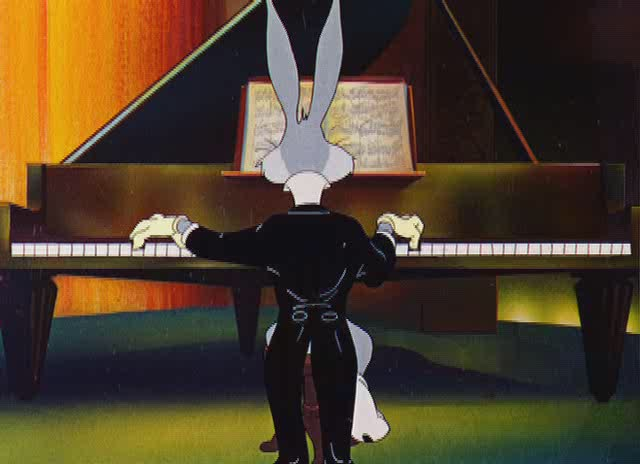

In [31]:
Image(os.path.join("images","bugs_piano.jpg"))

Over the summer, a favorite band (The Strokes) released yet another album that in my opinion, did not live up to their debut LP. As I looked online for other opinions on The Strokes' latest release, I became interested in at some point, actually looking into whether artists' first albums are typically reviewed more favorably than their other releases. When this project was assigned, my question over the summer -- namely, "Do first albums receive more favorable reviews than other albums do?" -- immediately popped back into my mind, and I took the opportunity to delve into it.

### Getting the data
To answer my research question, I wanted to look at critics' and casual listeners' reviews across many albums. Additionally, for each type of review -- those from critics and from casual listeners -- I wanted to aggregate reviews from as many sources as possible. This would decrease the influence of any one reviewer, making the final result as general as possible.

As I didn't find aggregated music reviews in an easily-accessible format online anywhere, my first step was to write a scraper for Metacritic.com -- a popular website that aggregates reviews (both from users and from critics) on many types of content, including music.

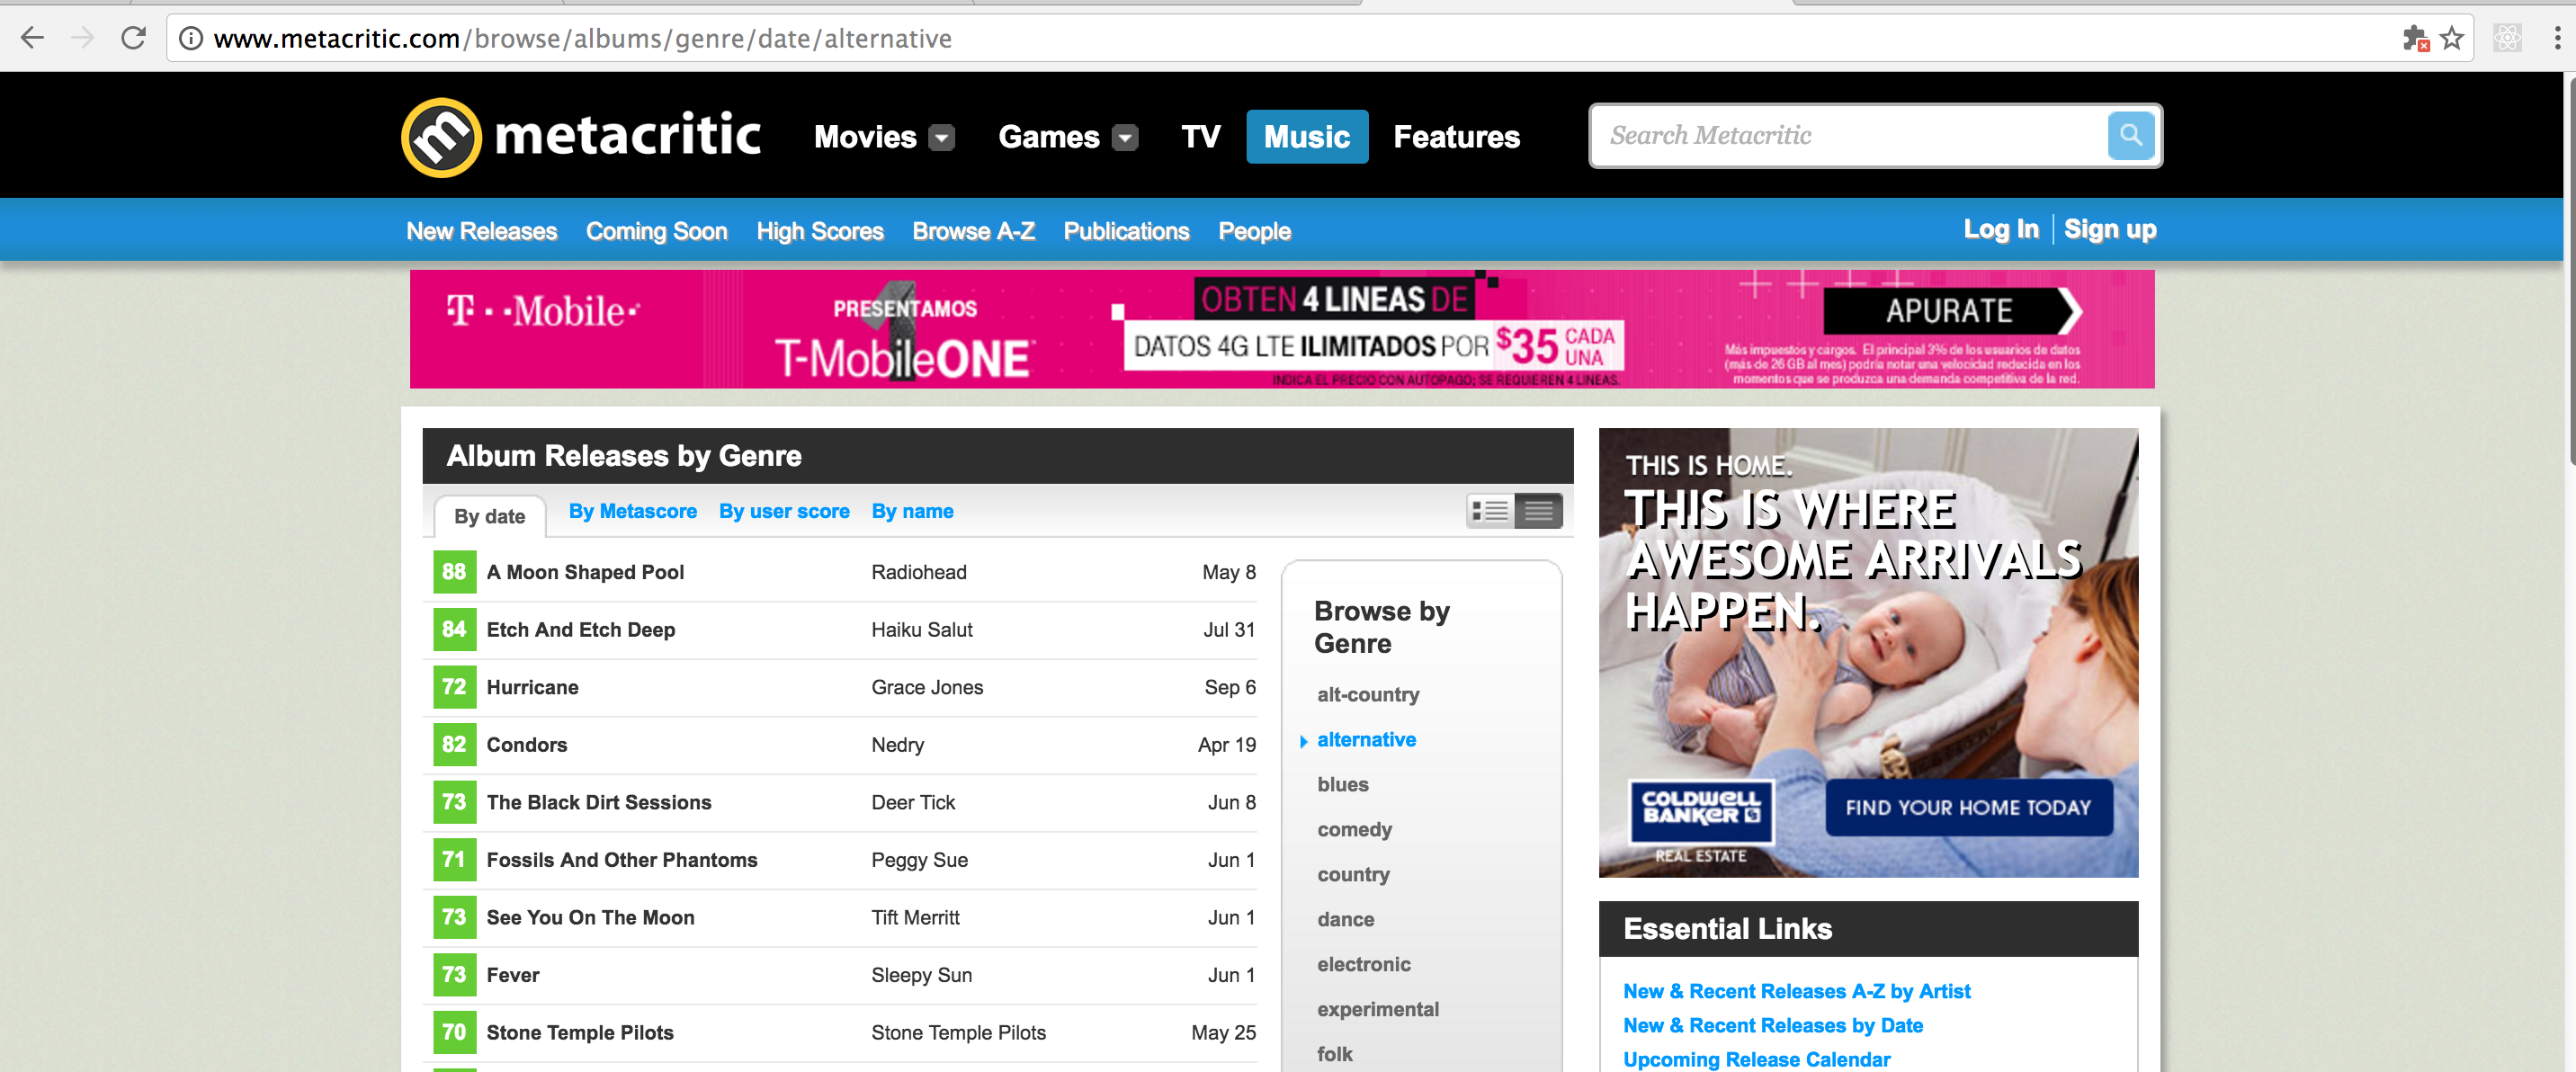

In [32]:
Image(os.path.join("images","metacritic_genre_browse.png"))

By having the scraper browse Metacritic by genre, I was able to get lists of artists, with each artist's Metacritic artist page URL -- which has the artist's discography, with user and critic reviews per album (averaged across reviewers). 

Metacritic explains that user scores are a simple "average user vote" of all user ratings. (http://www.metacritic.com/faq#item19) 

However, for critics' scores -- termed "Metascores" on their site -- the site indicates that they are computed with a weighted average, giving more weight to "some critics and publications than others, based on their quality and overall stature." (http://www.metacritic.com/about-metascores) They do not delve into more detail. 

Therefore, since I had no more information to go on, for the purposes of this analysis, I treated Metascores as if they gave each critic's review equal weight. 

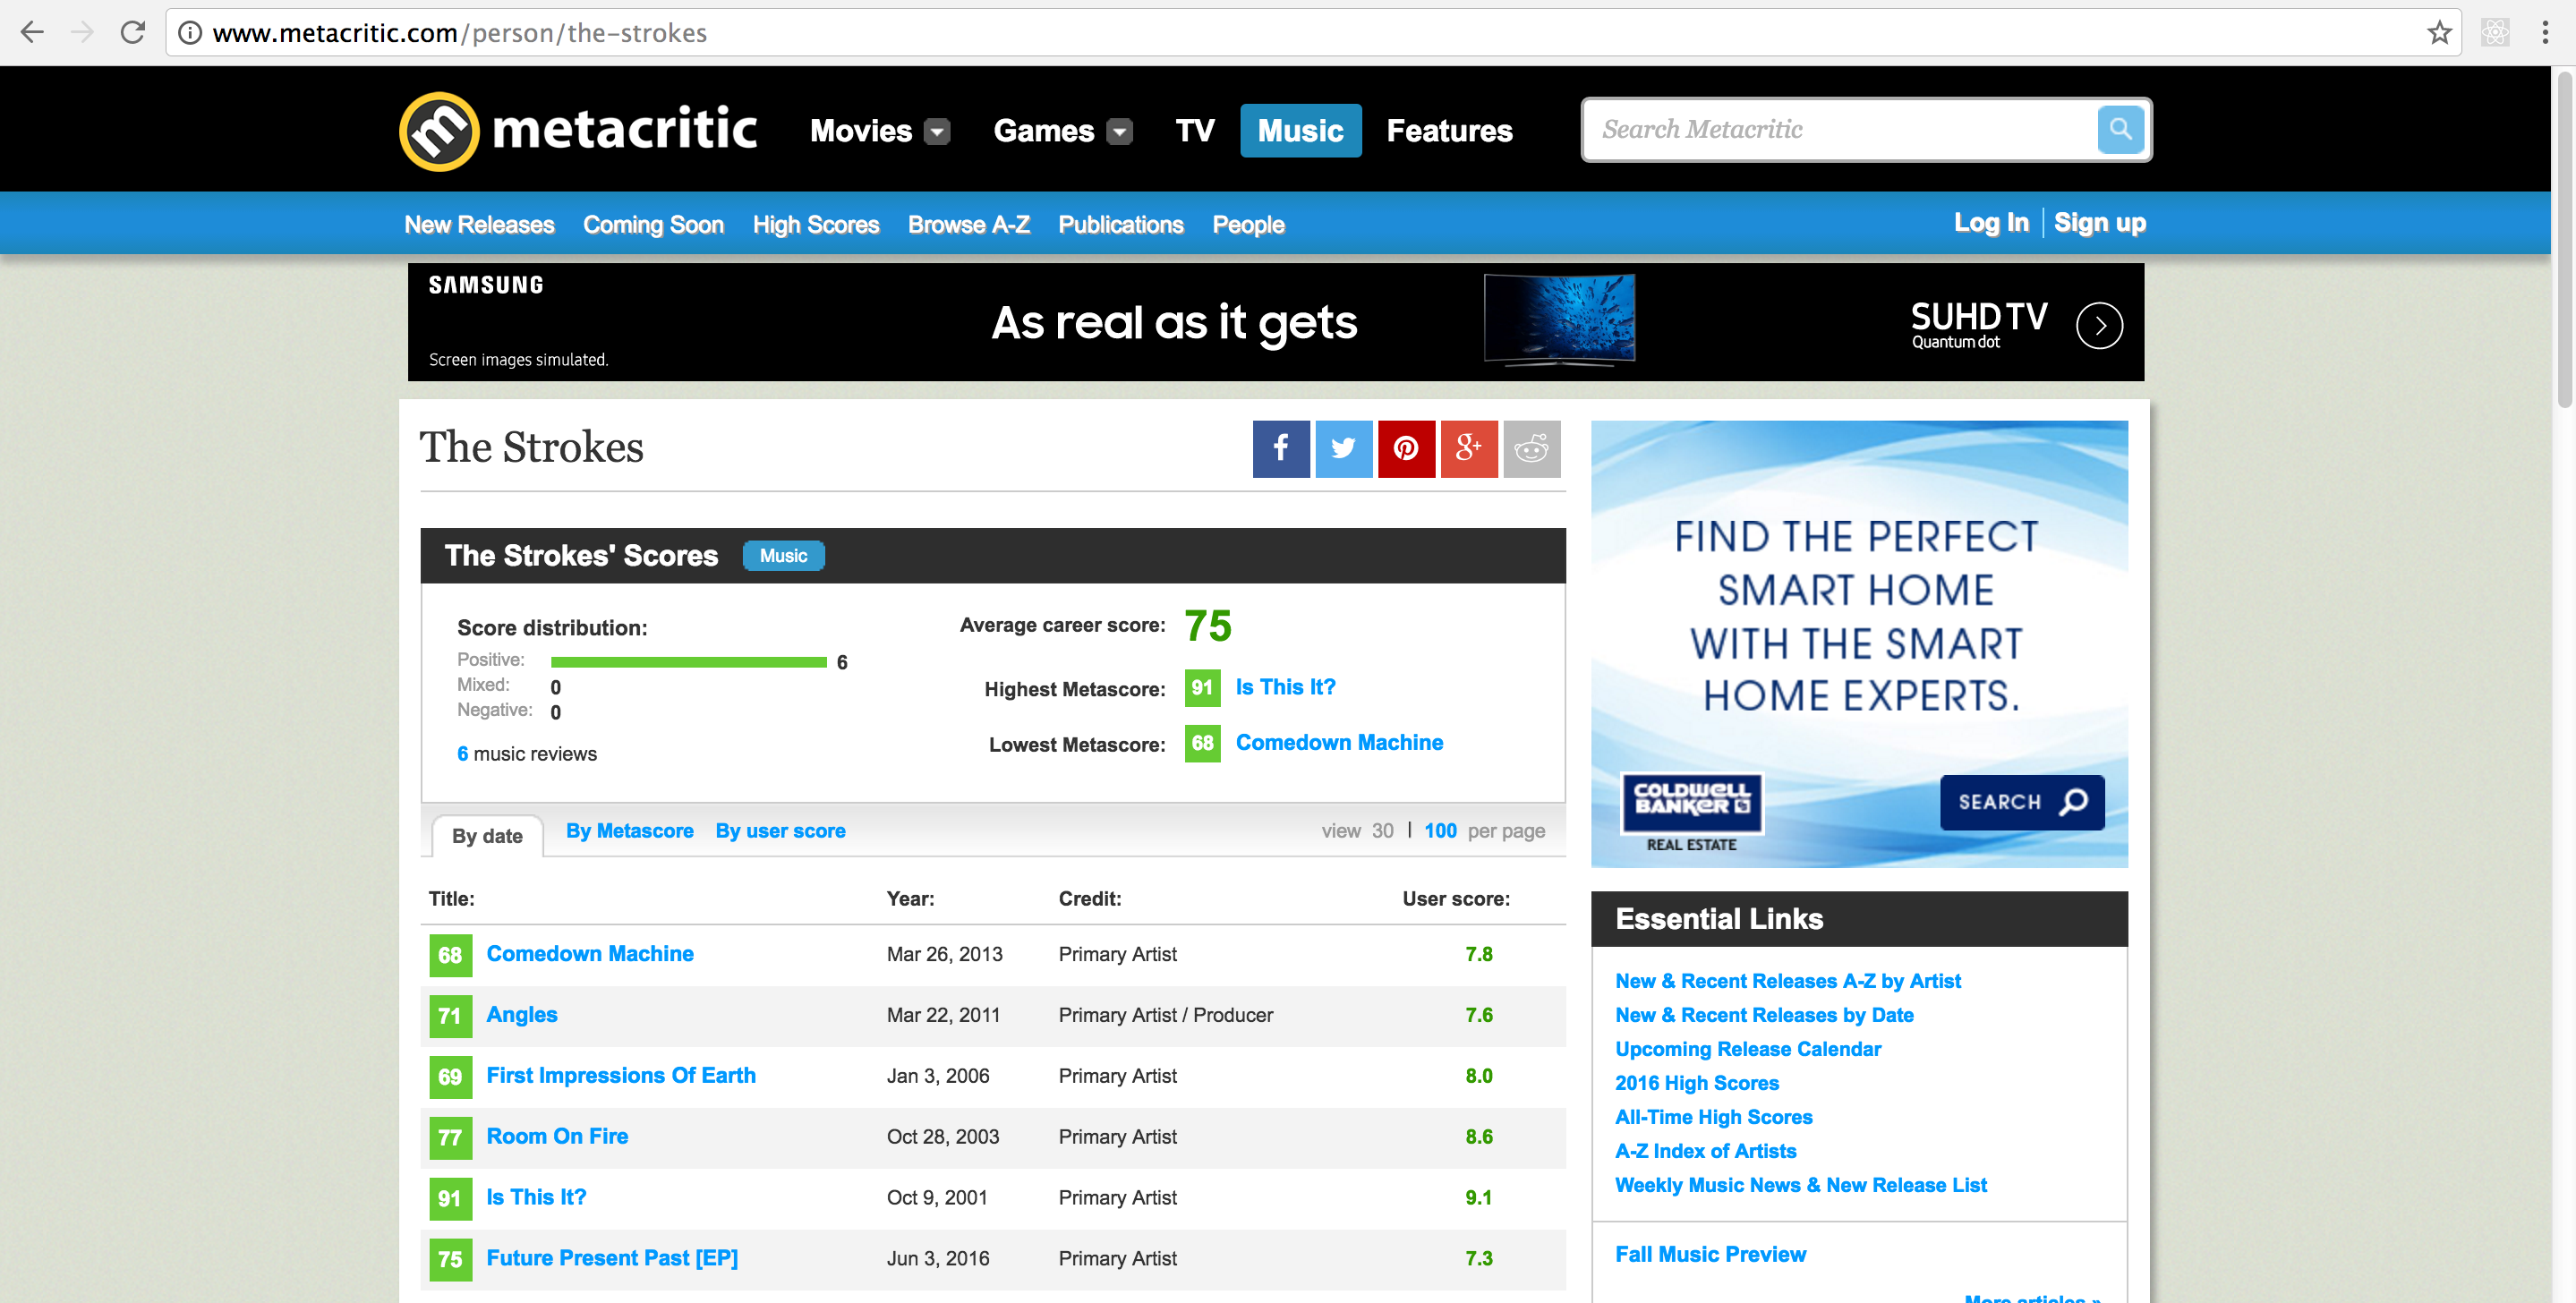

In [33]:
Image(os.path.join("images","metacritic_profile.png"))

##### Confirming complete discography on Metacritic
My initial research question required knowing which album was an artist's first, and having a rating for this album. I noticed that Metacritic did not seem to include reviews for albums released before its founding -- mid-1999. So if a band released albums both before and after mid-1999, the album with the earliest release date on the band's Metacritic page would not actually be the band's first release. The band's first release would not appear on the band's Metacritic page at all, and a later release would appear to be the band's debut album.  

So, I needed a way to confirm for each artist, whether its discography on Metacritic was, in fact, complete. I noticed, for a few artists I quickly sampled that I knew released albums before 2000, that Allmusic.com seemed to include all albums the bands had released. 

Therefore, for each artist I found on Metacritic, I scraped the artist's page on Allmusic.com. If I found an album on the band's Allmusic page that was released before 2000 (or if I could not find the band on Allmusic at all), I eliminated the band from my dataset. 

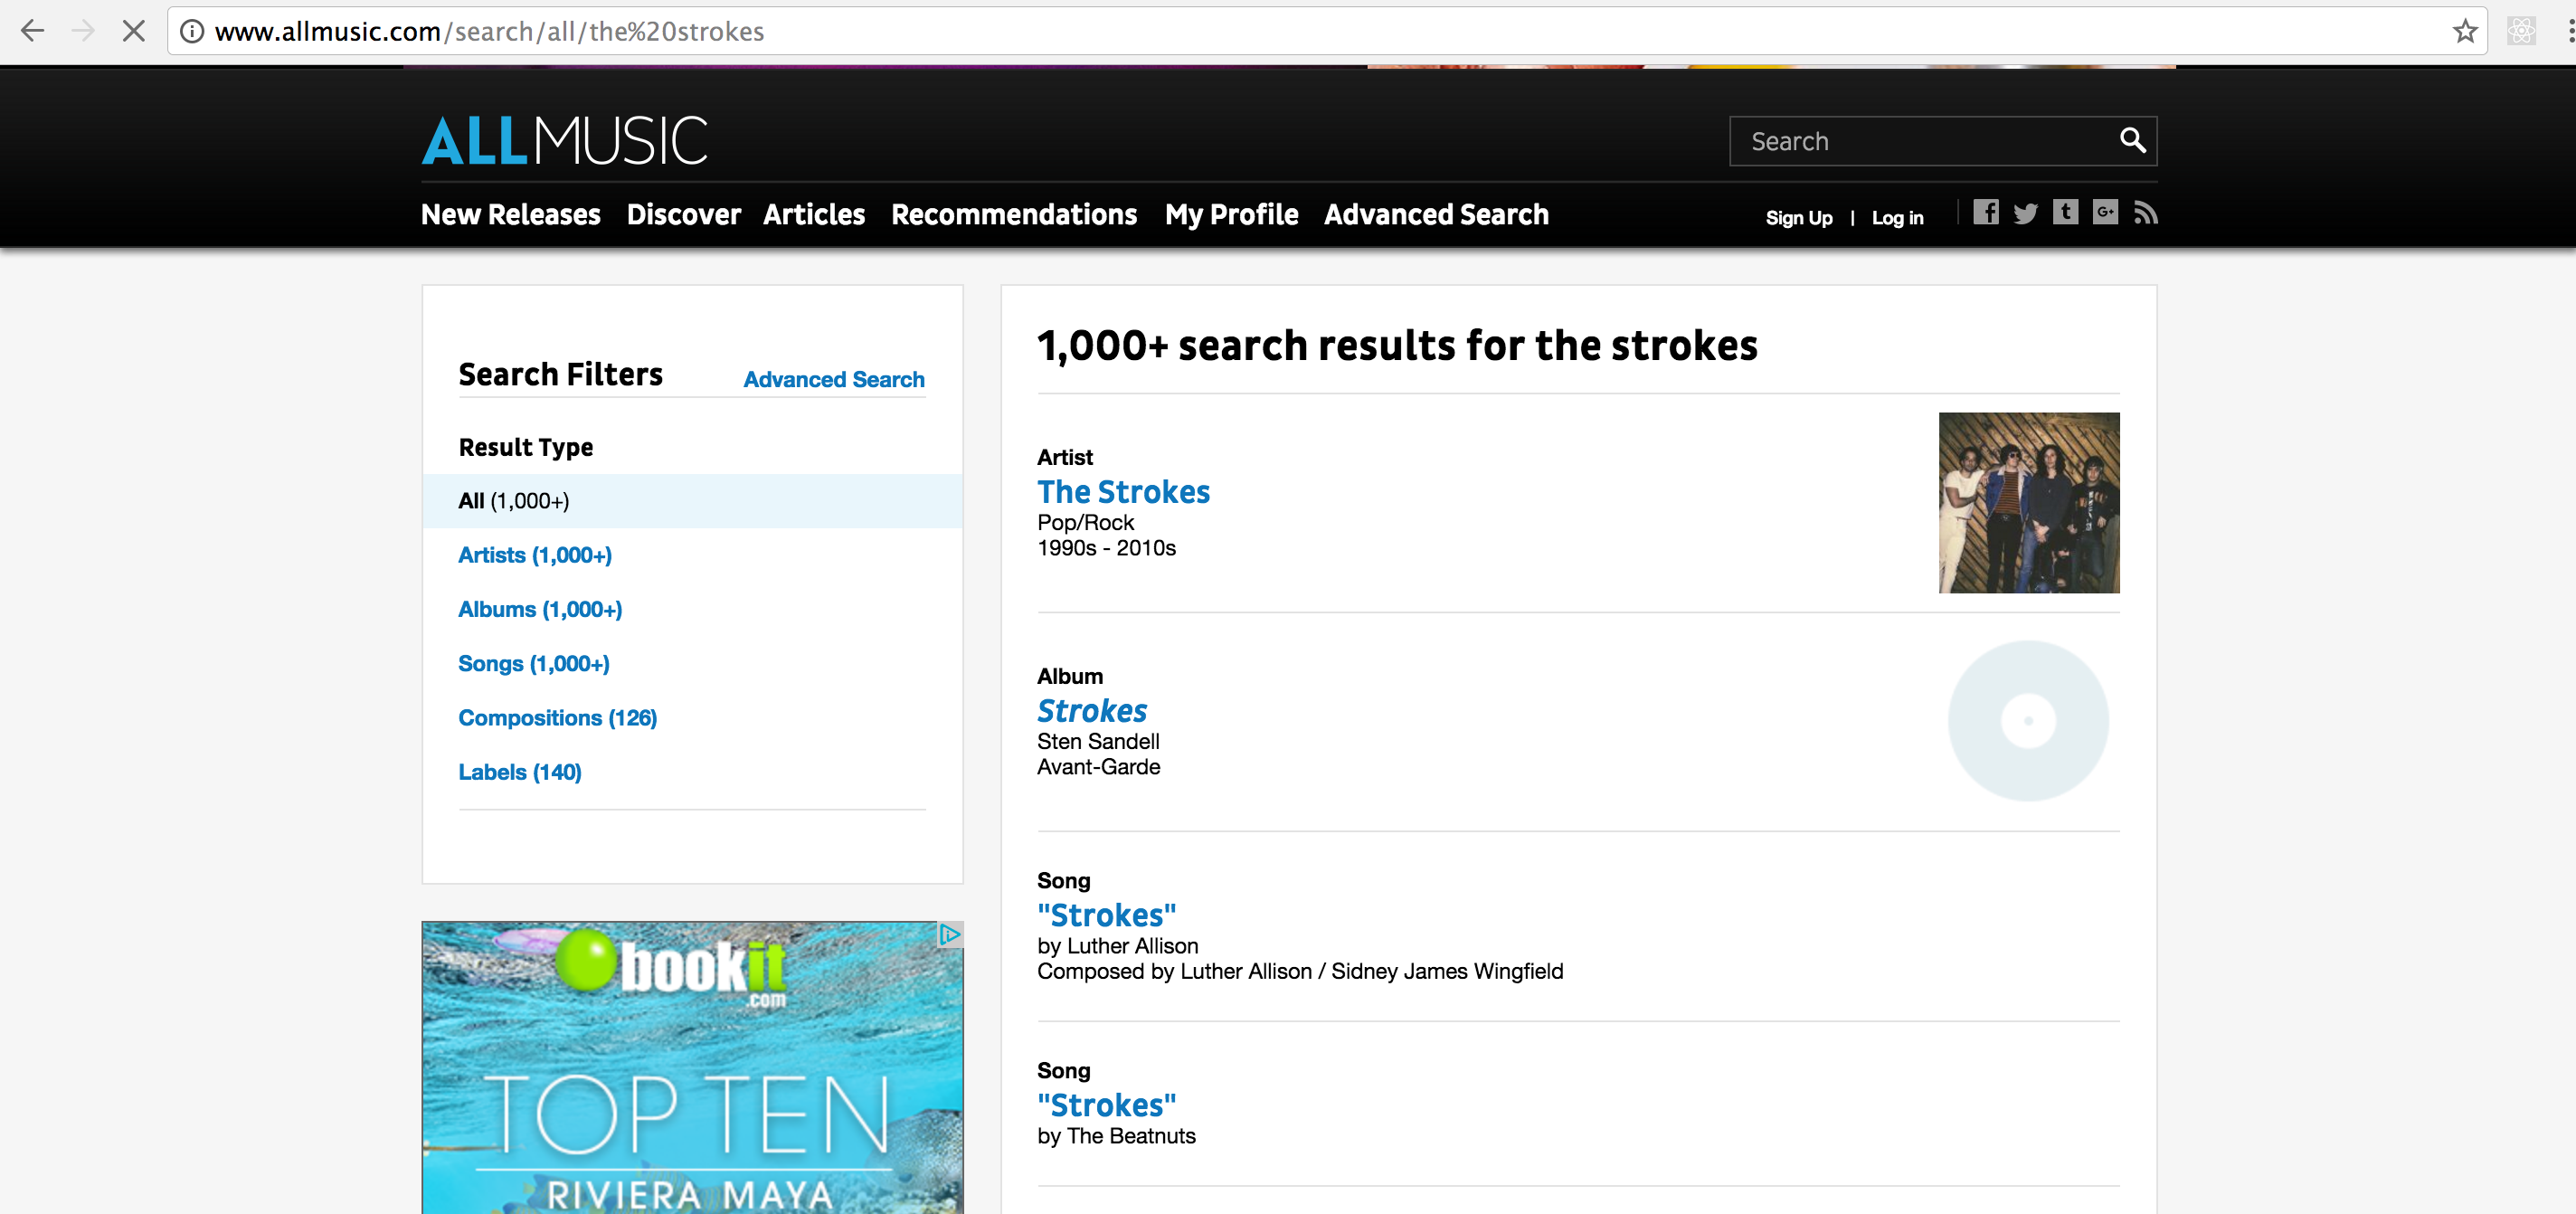

In [34]:
Image(os.path.join("images","allmusic_search.png"))

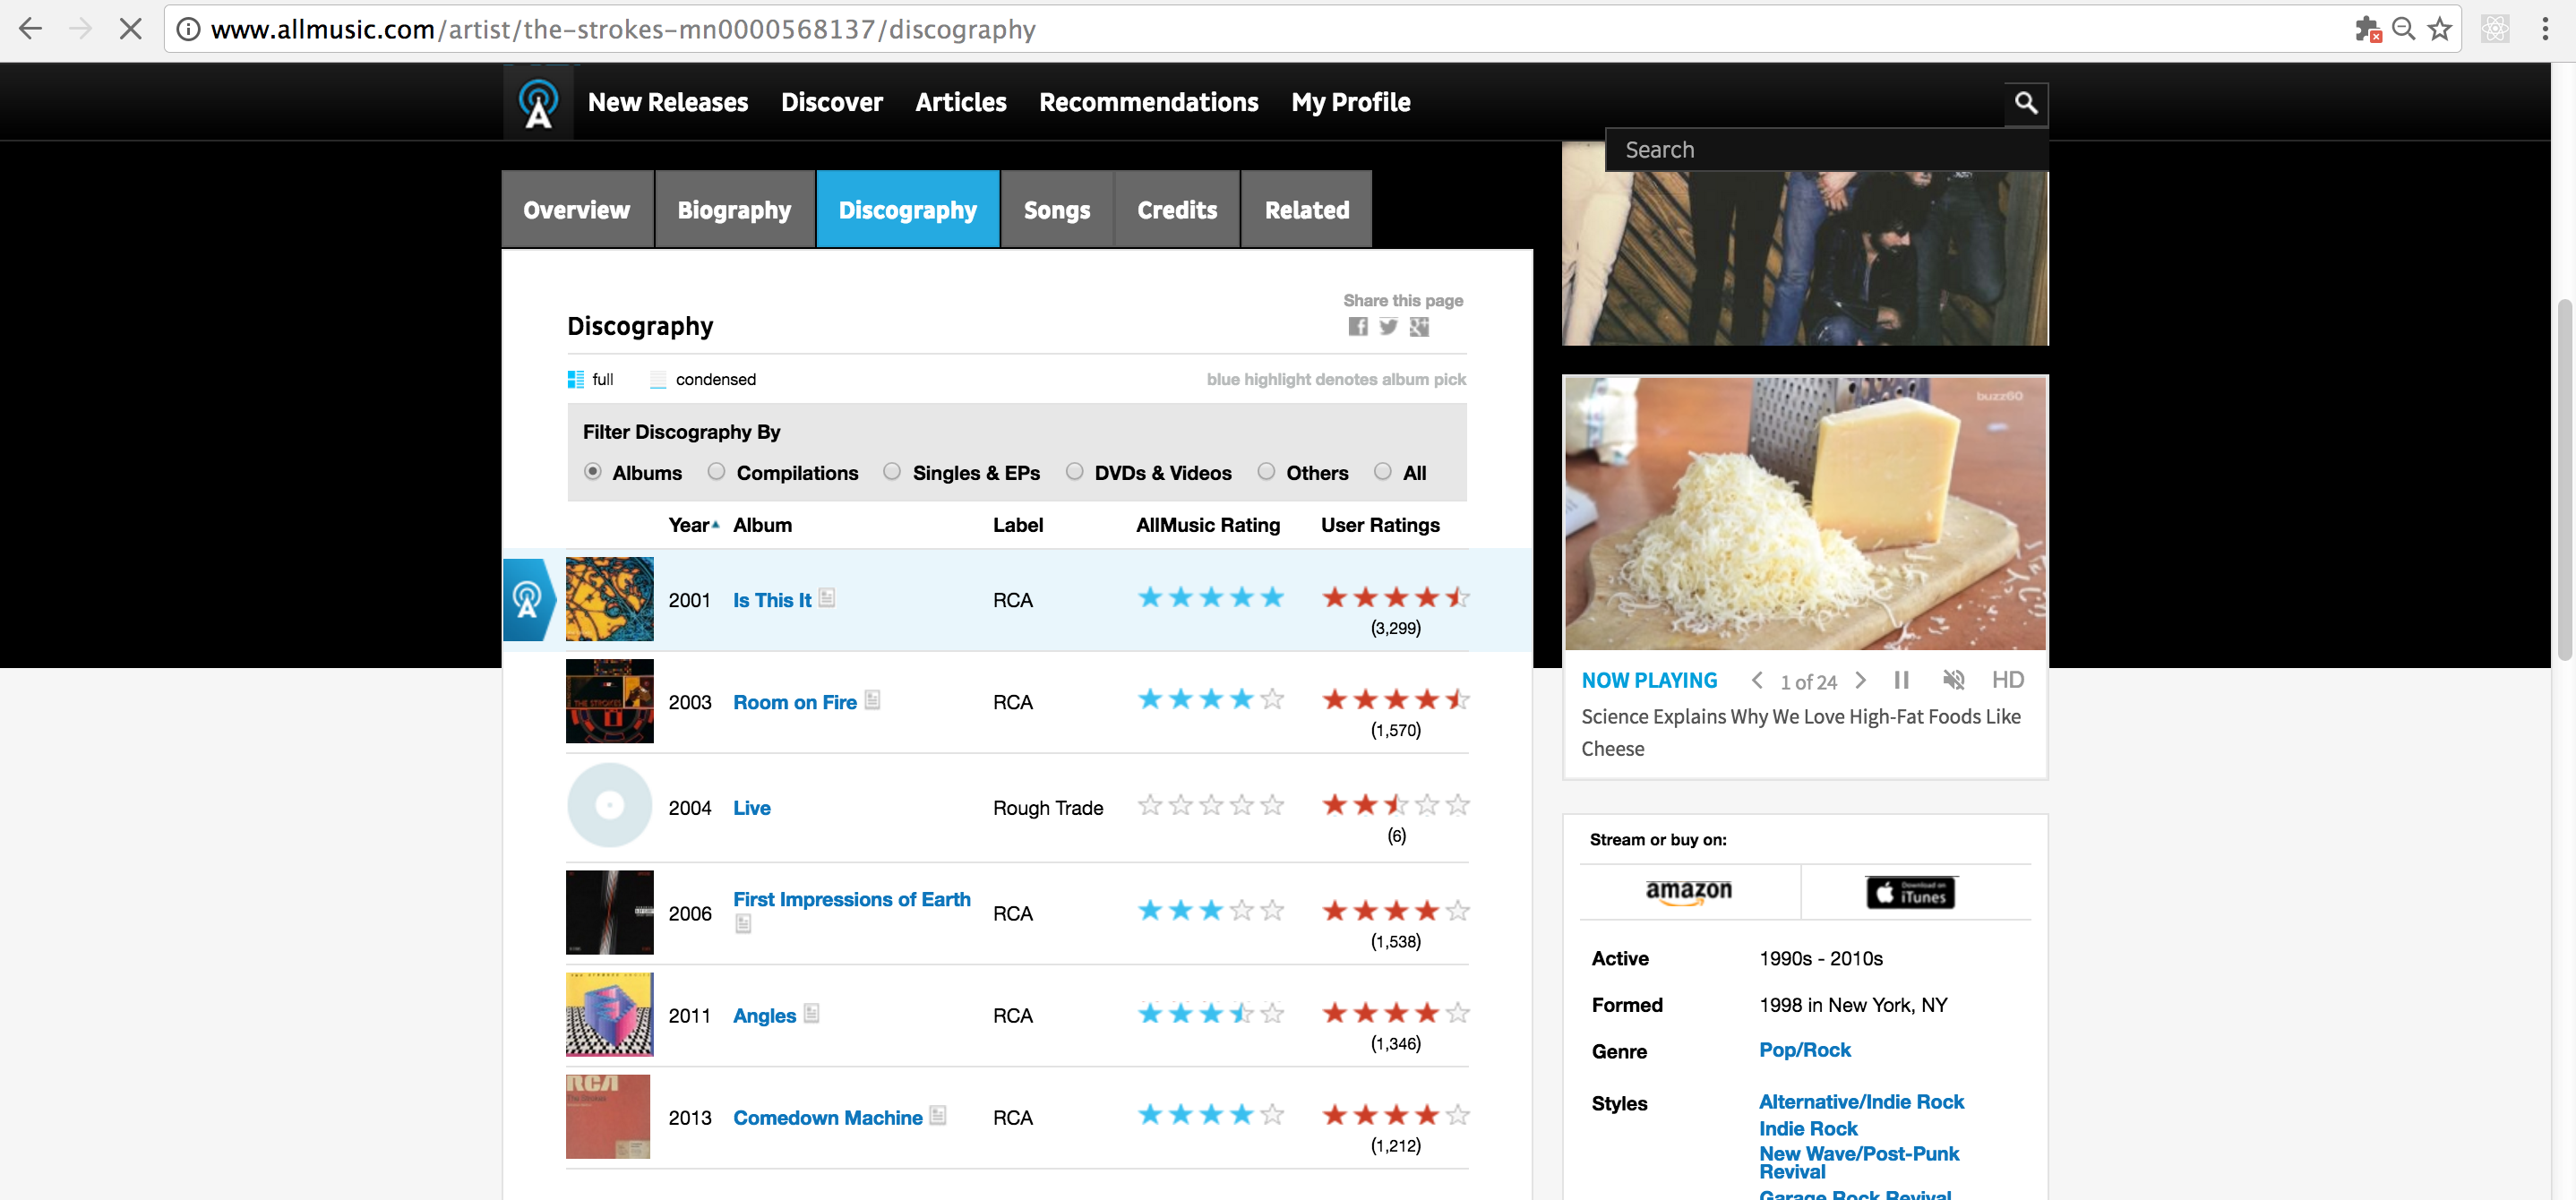

In [35]:
Image(os.path.join("images","allmusic_profile.png"))

### Assumptions
#### Timeframes covered by Metacritic and Allmusic data
As mentioned in the paragraph above, my goal was to have reviews for the complete discography of artists that I included in my analysis. In order for my process described above to work perfectly -- that is, using Allmusic to verify that an artist's Metacritic page included all of the artist's releases -- the following 2 assumptions must hold true:

1) For bands for which it has an artist page, Allmusic includes all albums released before 2000

2) For bands for which it has an artist page, Metacritic includes all albums released during or after 2000.

These assumptions may not entirely hold true, but they were assumptions I made in order to put together a large enough dataset in the amount of time we had.

#### Integrity of Metacritic's critic and user scores
I made other assumptions around the quality of Metacritic's reviews. Namely, I assumed that Metacritic's critic and user reviews were from legitimate critics and casual listeners. I assumed that Metacritic had a reasonable definition for who was considered a "critic." 

##### Equal Weighting
I also assumed that reviewers did not review a given album more than once, and that each reviewers' score was weighted equally. 

As noted in my "Getting the Data" section, various critics' scores are not weighted equally by Metacritic in determining the Metascore of an album. Rather, they weight critics' contributions based on the publication's "quality" and "overall stature." (http://www.metacritic.com/about-metascores)

However, as Metacritic does not provide more detail on this process, I had to treat critics' scores as if they were weighted equally.

##### Normalization
Metacritic also normalizes critics' scores "(akin to 'grading on a curve' in college), which prevents scores from clumping together." (http://www.metacritic.com/about-metascores) 

Once again, they do not seem willing to go into more detail on how this normalization is done. Metacritic's website, unfortunately, does not indicate that the same process is performed on users' scores. 

This complicates comparisons between users' and critics' scores, as the weighted means of critics' scores have been altered, while users' ratings have not been. Without more information on Metacritic's normalization process, I had no way of accounting for it in my analysis. 

#### The choice to review an album
As pointed out in the discussion of my midterm project, casual listeners likely have more say in whether or not to review any given album than critics do. Critics may be assigned albums to review by an employer.

However, for this project, I am assuming that the choice to review an album is not related to the score a reviewer ultimately assigns to the album. As such, for example, I am assuming casual listeners' scores captured by Metacritic do not disproportionately reflect opinions of users who were extremely pleased or displeased with a particular album. Rather, I am assuming these scores capture users' opinions about a given album in a way that representatively reflects the true population of users' opinions. 

#### Album quality, as measured by review score, has not changed over time
In my conclusions, I attempt to generalize from the sample of data I scraped from Metacritic to all albums ever released in the sampled genres. As my Metacritic sample only includes data from the year 2000 to the present, in order to generalize in this way, I am assuming album quality, as measured by review score, has not changed since these genres first came about.

In [36]:
# load review data, which has been saved in JSON files, into dictionaries
rock_artists_albums = pr.json_to_dict_artists_albums(os.path.join('data','rock-artists-albums.json'))
indie_artists_albums = pr.json_to_dict_artists_albums(os.path.join('data','indie-artists-albums.json'))
pop_artists_albums = pr.json_to_dict_artists_albums(os.path.join('data','pop-artists-albums.json'))
alternative_artists_albums = pr.json_to_dict_artists_albums(os.path.join('data','alternative-artists-albums.json'))

# Preprocessing

#### Removed artists that released albums before 2000
As described in my "Getting the data" section above, from my cursory research, Metacritic only includes albums released during or after 2000 (actually mid-1999, but I chose 2000 for a round cutoff date). 

To ensure that I had complete discographies for those artists included in my analysis, I removed those artists that had a Metacritic page, but that either: 
+ 1) according to Allmusic.com, released an album before 2000 (which indicated that Metacritic would not include their complete discography)
+ 2) could not be found on Allmusic.com (as therefore, the completeness of the artist's Metacritic page could not be verified)

This eliminated the following numbers of artists, per genre:
+ Rock: 1082 artists eliminated
+ Indie: 551 artists eliminated
+ Pop: 274 artists eliminated
+ Alternative: 472 artists eliminated

#### Removed albums for which the artist was not a "Primary Artist" on Metacritic

For each artist, I removed those albums for which the artist was not listed as a "Primary Artist." If the artist was a producer or featured guest on another band's album, I did not want that album's score included in their career trajectory.

This is another assumption -- that is, Metacritic will have this label assigned properly.

Albums removed due to listed artist not being a "Primary Artist":

+ Rock: 70
+ Indie: 37
+ Pop: 28
+ Alternative: 26

The Pop genre also had 4 artists that were removed entirely in this process -- as after removing albums for which these artists were not a "Primary Artist," the artists had no albums left.

#### Scale
Metacritic has critics' scores as integers out of 100, and users' scores as floats out of 10.0 -- so I multiplied users' scores by 10 so that both score types would be on a 100-point scale. 

In [37]:
pr.field_preprocessing(rock_artists_albums)
pr.field_preprocessing(indie_artists_albums)
pr.field_preprocessing(pop_artists_albums)
pr.field_preprocessing(alternative_artists_albums)

I then took the union of the 4 dictionaries of artists' albums -- 1 for each genre that I had scraped -- and performed my analysis on the resulting dictionary. 

In [38]:
all_genres = pr.dictionary_union([rock_artists_albums, indie_artists_albums, pop_artists_albums, alternative_artists_albums])

In [39]:
all_albums_list = pr.simplify_datastore(all_genres)
df = pd.DataFrame(all_albums_list)
df.columns = ['critic_score', 'album_title', 'release_date', 'role', 'user_score', 'release_date_formatted', 'artist', 'artist_id','album_number']

### Exploratory Data Analysis

In [40]:
print(len(all_genres), "artists in total")

1344 artists in total


##### Artists per Genre
In assembling Metacritic's data, I browsed the website's music reviews by genre. This provides a list of albums the site includes in a given genre. I performed this process for the Rock, Indie, Alternative, and Pop genres. 

For each album in the genre I was currently browsing, I went to the artist's Metacritic page and saved reviews of all of the artist's albums as part of the current genre dictionary. This was to ensure that, in case an artist released somes albums within Rock, Indie, Alternative, and Pop, and some albums that were classified as a different genre than these four, that I would still include all of the artist's releases. 

Therefore, in my dictionaries, artists are included in each of the four genres for which they have released an album according to Metacritic. Metacritic may list an album as part of multiple genres. Therefore, there will be many artists that are included in multiple genres. 

I did not spend much time analyzing genre differences as:
+ 1) I was not sure that browsing by genre listed all albums I wanted to include. 

For example, Metacritic uses many labels for nuances within these genres. Just within the Pop category, I have seen labels Pop, Synth Pop, Pop/Rock, and others. Does browsing the Pop genre bring up all albums listed as a sub-category of Pop? I could not tell.

+ 2) I was not sure that there were clear, consistent differences within genre assignments. 

For example, what is the difference between an album assigned both "Pop" and "Rock" labels, and an album assigned "Pop/Rock"? 

I chose instead to simply use the "Browse by Genre" feature on Metacritic to gather a large amount of data on loosely defined categories of music that I am interested in.

1165 artists in the rock genre
801 artists in the indie genre
296 artists in the alternative genre
365 artists in the pop genre


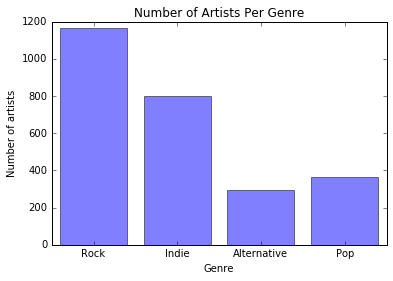

Summing the counts of artists per genre yields 2627 artists, nearly twice the count of unique artists


In [41]:
analysis.print_num_artists_per_genre(rock_artists_albums, indie_artists_albums, alternative_artists_albums, pop_artists_albums)

##### Album Releases per Year
I next broke down the number of album releases per year I had in Metacritic's data. 

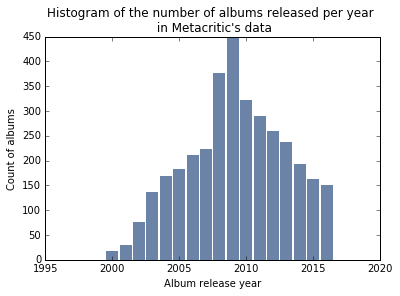

In [42]:
yearly_albums_hist = ts2.Hist([rd.year for rd in df['release_date_formatted']])
tp.Hist(yearly_albums_hist)
tp.Show(xlabel='Album release year', ylabel='Count of albums', title="Histogram of the number of albums released per year \n in Metacritic's data")

##### 2000 - 2009
The increase in albums per year from 2000 to 2009 made sense at first glance. It would seem likely that artists that released albums in the early 2000s would have a greater probability of releasing an album before 2000 as well, which would exclude the artist from my dataset. (As mentioned earlier, I excluded artists that released albums before 2000, as those releases were not included in Metacritic's data.)

##### 2009 - present
However, the decrease in albums per year from 2009 to the present surprised me a bit. This trend could have occurred for any number of reasons, such as:
+ 1) Metacritic changing its methodology for classifying albums into genres, which could have resulted in fewer albums classified as one of the four that I scraped
+ 2) Metacritic changing its business model, such that music reviews were no longer as high of a priority
+ 3) Record companies actually releasing fewer albums in these genres

I did not look further into this surprising trend, as I did not have the data to investigate many of my ideas for potential causes listed above. 

### Number of Albums per Artist

In total, 1344 artists, producing 3489 albums.
An average of 2.60 albums per artist.
42 artists with more than 6 albums.


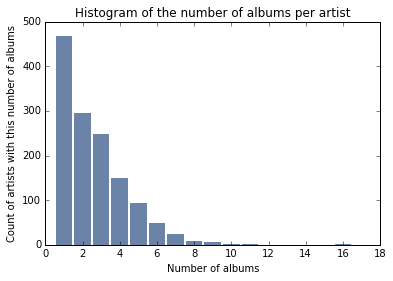

In [43]:
analysis.print_num_albums_per_artist(all_genres)

## Onto the analysis
##### Much of the code & methodology I used for this analysis was borrowed directly from Allen Downey's ThinkStats2.

### Do casual listeners assign higher review scores to first albums than to other albums?

According to the data pulled from Metacritic, casual listeners rated first albums 2.64 points better than they rated other albums -- in other words, 3.39% better.

Mean USER score for a FIRST album: 80.63
Mean USER score for an OTHER album: 77.99
Difference: 2.64
FIRST albums rated 3.39 percent BETTER


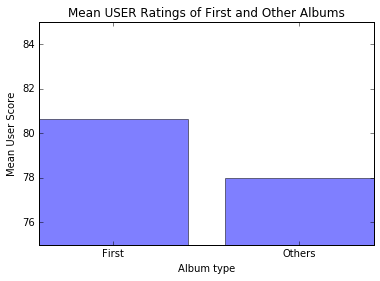

In [44]:
# If, on Metacritic.com, an album has too few user or critic scores, 
# the value for the respective score type will be 'tbd'
# Remove 'tbd' values before calculating statistics
def remove_tbd(np_arr):
    return np_arr[np_arr != 'tbd']

# 1st albums
first_albums = df[df['album_number'] == 1]
first_albums_critics = remove_tbd(first_albums['critic_score'])
first_albums_users = remove_tbd(first_albums['user_score'])

# Other albums
other_albums = df[df['album_number'] != 1]
other_albums_critics = remove_tbd(other_albums['critic_score'])
other_albums_users = remove_tbd(other_albums['user_score'])

analysis.print_users_first_albums_observed_effect(first_albums_users, other_albums_users)

##### Testing statistical significance
To test whether this apparent effect likely reflects a real difference in the population of all albums of these genres ever released, or instead appears in my data sample by chance, I ran a hypothesis test. 

My apparent effect is casual listeners' scores of first albums are 2.64 points greater than their scores of other albums. My hypothesis -- from my personal anecdotal experience with The Strokes career trajectory, and from this apparent effect -- is that in the population of all albums within these genres, casual listeners' rate first albums more favorably than other albums. Therefore, I will choose a one-sided test statistic -- that is, the mean of casual listeners' first album scores minus the mean of their other album scores. 

The null hypothesis assumes the apparent effect is due to chance, so, in this case, it is that casual listeners' scores of first albums and other albums actually are from the same distribution. We can formulate the null hypothesis by concatenating the lists of casual listeners' scores of first and other albums, and permuting the values -- which yields a single distribution. 

By repeating the process of permuting the values in our single list, and assigning 1 portion to be users' first album scores and the rest to be users' other album scores, we can quantify the percentage of the simulations that produce a test statistic greater than or equal to my apparent effect. 

The idea and code for this hypothesis test was pulled from Downey's ThinkStats2.

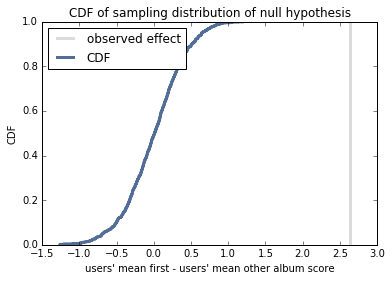

Calculated p-value: 0.0


In [45]:
data = first_albums_users.values, other_albums_users.values
analysis.PrintDiffMeansOneSided(data, title="CDF of sampling distribution of null hypothesis", label="users' mean first - users' mean other album score")

As I drew 1000 samples under the null hypothesis, and not 1 yielded a test statistic as large as my apparent effect, I can say my p-value < .001.

The apparent effect is statistically significant. It is extremely unlikely that in Metacritic's sample, casual listeners would rate artists' first releases 2.64 points better than they rate other releases, if in the population, users' first and other album scores are from the same distribution.

### Now the same question, but for critics -- that is, do critics assign higher review scores to first albums than to other albums?


Based on my sample of data from Metacritic, critics score first albums 0.08 points worse than they score other albums -- in other words, 0.12% worse.

It is worth noting that, as mentioned in my "Assumptions" section, Metacritic performs normalization and unequal weighting on critics' scores that are not fully explained. It is impossible to say what portion of this apparent effect, or lack thereof, is due to these factors.

Mean CRITIC score for a FIRST album: 70.96875
Mean CRITIC score for an OTHER album: 71.051474029
Difference: -0.0827240290126
FIRST albums rated -0.12 percent WORSE


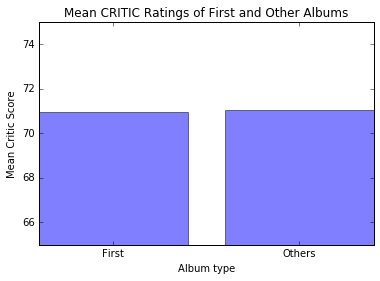

In [46]:
analysis.print_critics_first_albums_observed_effect(first_albums_critics, other_albums_critics)

For the sake of completeness, I also tested the likelihood this tiny apparent effect would occur by chance, given the null hypothesis. 

Much of this work is analagous to the hypothesis test performed directly above for the difference in users' scores between first and other albums. In this case, I also used a one-sided test statistic, but here, the test stat is other album scores minus first album scores, instead -- as I observed critics' scores of other albums being ever so slightly better than their scores of first albums. 

The null hypothesis and the simulation process are the same as described in the section above.

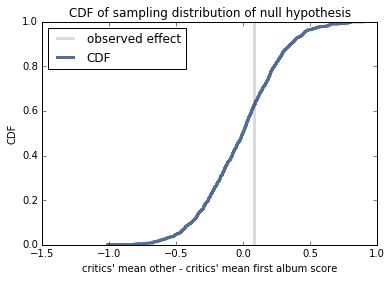

Calculated p-value: 0.375


In [47]:
data = other_albums_critics.values, first_albums_critics.values
analysis.PrintDiffMeansOneSided(data, title="CDF of sampling distribution of null hypothesis", label="critics' mean other - critics' mean first album score")

The small apparent effect is, clearly, not statistically significant (p-value printed above). The apparent effect of critics rating other albums very slightly better than first albums in Metacritic's data would be likely to occur by chance if the null hypothesis is true. Once again, the null hypothesis here is that in the population, there is no difference in critics' mean first and mean other album scores, and they instead come from the same distribution. 

## Do critics give albums worse scores than casual listeners do?

I noted in the my midterm project that, while looking into my primary research question, I noticed that critics seemed to rate albums less favorably than users did. 

As noted in my "Assumptions" section, Metacritic normalized critics' scores via some process that they choose not to fully explain, and unfortunately, they do not indicate that they perform the same normalization process on users' scores. Additionally, various critics' do not contribute equally to the final averaged critics' score for a given album, whereas users' scores appear to be equally weighted. 

I could not analyze what portion of the apparent difference in means between users' and critics' scores was due to the above discrepancies in the way Metacritic treated the two score types, as Metacritic does not provide enough detail for me to do so.

Ignoring those issues, I decided to also test the statistical significance of this apparent effect, since it caught my interest, and the apparent effect was large.

Mean CRITIC score: 71.02
Mean USER score: 79.01

USER mean - CRITIC mean: 7.99
Users rated albums 11.26 percent higher than critics did.

Effect size (Cohen's D) of 0.81


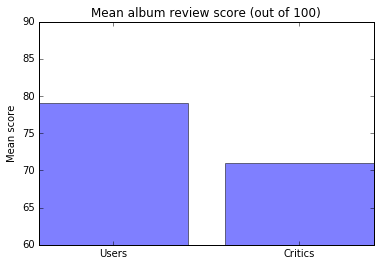

In [48]:
critics_scores = remove_tbd(df['critic_score'])
users_scores = remove_tbd(df['user_score'])
analysis.print_critics_users_diff(users_scores, critics_scores)

To test the statistical significance of this apparent effect, I conducted a hypothesis test with a one-sided test statistic. My test statistic was the mean user score minus the mean critic score. 

As with my hypotheses tests above, here I once again simulated the null hypothesis by concatenating the 2 lists of values -- users' and critics' ratings -- and permuting the concatenated list. The null hypothesis is that users' and critics' scores are from the same distribution. Therefore, repeatedly permuting this single list and assigning a portion to be users' scores and the rest to be critics' scores can be used to test how often an effect as large or larger than the apparent effect would occur simply by chance if the null hypothesis is true.

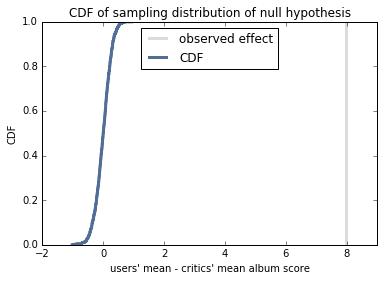

Computed p-value: 0.0


In [49]:
data = users_scores.values, critics_scores.values
ht = hyp.DiffMeansOneSided(data)
pvalue = ht.PValue()
ht.PlotCdf(label='CDF')
tp.Config(loc=9)
tp.Show(xlabel="users' mean - critics' mean album score", ylabel='CDF', xlim=[-2,9], title="CDF of sampling distribution of null hypothesis")
print("Computed p-value:", pvalue)

As none of the 1000 runs of this simulation yielded a test statistic value that was greater than or equal to my apparent effect, we can say that the p-value < .001. 

The apparent effect -- casual listeners' mean rating was 7.99 points greater than critics' mean rating -- would be extremely unlikely to occcur by chance in the sample of data I scraped from Metacritic if the null hypothesis were true. (Once again, I cannot account for the impact of Metacritic's critics' score weighting and normalization processes described in my "Assumptions" section.)

## Estimating Users' Mean First Album Score
Say, if you worked at record company, and wanted to know if a newly signed band's first release was better received by casual listeners than first releases typically are. If the record company had access to a sample of data, like this sample from Metacritic, they may want to use it to generalize to all albums ever released within this set of genres (Indie, Pop, Alternative, Rock). 

Therefore, the record company might want to: 
+ 1) choose the best way to estimate users' mean first album score for this population, and 
+ 2) quantify how much the estimate may vary simply because it is from a sample of data rather than the population (sampling error)

##### Sample mean vs. sample median
To begin addressing these goals, the company may calculate 2 of the more common ways to estimate a population mean -- namely, the sample median and sample mean.

In [50]:
print("Users' sample MEAN First Album Score:", "%.2f" % first_albums_users.mean())
print("Users' sample MEDIAN First Album Score:", "%.2f" % np.median(first_albums_users))

Users' sample MEAN First Album Score: 80.63
Users' sample MEDIAN First Album Score: 83.00


##### Minimizing error
The next step is to investigate which sample statistic is the better choice as an estimator. I'm assuming the costs of overestimating and underestimating the true users' mean first album score are symmetric. That is, for example, I am assuming it is not clearly worse to overestimate this mean than to underestimate it, and vice versa. 

Additionally, there seems to be no advantage to estimating population mean exactly correctly in some samples at the cost of increased errors in others. If this were the case, we would choose a maximum likelihood estimator. 

It would therefore make sense for the company to choose the statistic that minimizes the error of the estimate. 

##### Unbiased estimators
It would also be preferable if the estimator did not tend towards consistently overestimating or underestimating the true parameter -- that is, we would like an unbiased estimator. 

Sample size of first albums reviewed by users is 1233

Standard Error xbar 0.32
Standard Error median 2.43
90% Confidence Interval: ( 80.09 , 81.15 )


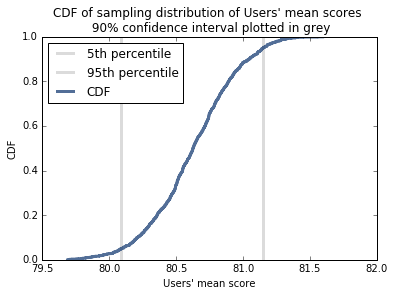

In [51]:
analysis.PlotSamplingDistribution(first_albums_users)

##### Simulation
I simulated the process of taking 1000 samples, each sample the size of the data set I scraped from Metacritic (1233 users' scores of first albums). Each of the 1000 samples was drawn by randomly sampling, with replacement, from my data scraped from Metacritic. This simulates the process of repeatedly sampling from a population that has the same distribution as that of my sample of data from Metacritic.

##### Standard error
With these parameters, the simulation produces a statistic known as "standard error," which calculates variations in our estimates due to sampling error. 

To compute standard error, we observe how much the estimate produced by each estimator (sample mean and sample median, here) varies from our supposed true population value. 

In this experiment, I assume the true population parameter is the mean I observed in Metacritic's data, and I measure how much the mean and median of data samples from this population would vary if this were the case. 

The difference between the estimates in this simulation and the supposed true value are the errors the estimators produce. Each of these errors is squared (so that positive and negative values both contribute positively to the total error, and so larger errors are magnified), and then the mean is taken. Finally, the square root of this mean -- the root mean squared error (RMSE) -- is reported as standard error. 

The standard error for the sample mean and median are printed with the graph above.

Therefore, in this case, the sample mean provides a less variable estimate of the population mean than the sample median does -- as the sample mean has a lower standard error. 

In [52]:
# evaluating estimator bias
iters = 100
while iters <= 100000:
    analysis.estimate_mean_error(first_albums_users,iters)
    iters *= 10

100 iterations
Mean Error xbar -0.0279318734793
Mean Error sample median 2.43658556367 

1000 iterations
Mean Error xbar -0.00351743714518
Mean Error sample median 2.42258556367 

10000 iterations
Mean Error xbar -0.00314436334145
Mean Error sample median 2.40958556367 

100000 iterations
Mean Error xbar -0.00169488240065
Mean Error sample median 2.41098556367 



##### Evaluating Bias
As the mean error for the sample mean approaches 0 as the number of runs of the simulation increases, the sample mean is an unbiased estimator of the population mean. 

However, the mean error for the sample median does not seem to approach 0 with increasing iterations. Instead, it seems to hover around 2.4, and therefore appears to be biased towards overestimating the population mean. 

##### Sample mean chosen as our estimator
Since the sample mean has a lower standard error than the sample median, and is unbiased, the hypothetical record company I mentioned earlier should prefer the sample mean as an estimator for the population mean in this case. 

##### Using users' sample mean first album rating, the record company's best estimate for users' mean score of all first albums in these genres would be 80.63.

### Relationship Between Critics' and Users' Scores
As I was wrapping up the project, after spending time measuring the statistical significance of the difference in mean scores for users and critics, I became interested in looking further into the relationship between these two types of scores.

Often, a record company will send an album to an array of critics for a review before the album is released. The company may wish to use the results of these early critics' reviews to predict users' ratings, perhaps thinking that user sentiment regarding the album may be a better indicator of commercial success. 

As mentioned in my "Assumptions" section, Metacritic does not weight various critics' scores equally, and normalizes the resulting scores. For predicting users' scores, I will assume the record label will use critics' scores that were calculated via Metacritic's weighting and normalization process.

##### Pearson's Correlation
In the data scraped from Metacritic, there is a 0.39 Pearson's correlation between critics' and users' album ratings, representing the strength of the linear relationship between these two variables (see graph below).

##### Hypothesis Testing the Correlation
I investigated the likelihood of this measured correlation occurring by chance in my sample, if in the population, the variables are truly unrelated. Since I expected a positive correlation between the two score types -- critics' and users' -- and since that is what I observed in my sample, my test statistic was one-sided. My test statistic was the correlation between the two variables, users' score and critics' score. (A two-sided test statistic here would have used the absolute value of this correlation.)

To simulate the situation where the two variables were not related (the null hypothesis), one list was permuted. The critics' score and users' score for a given album were originally paired by index position in their respective lists, so permuting one list created random pairings of users' and critics' scores. 

This idea and code for hypothesis testing of a correlation was borrowed, once again, from Downey's ThinkStats2.

##### Statistical Significance
This simulation yielded a p-value < .001, so the observed correlation is statistically significant. It is very unlikely that a linear relationship of this strength (Pearson's correlation of 0.39) would exist in Metacritic's data if there is no linear relationship between critics' and users' scores in the population of all albums within these genres. 

Pearson's correlation between critics' and users' scores: 0.39
Computed p-value: 0.0


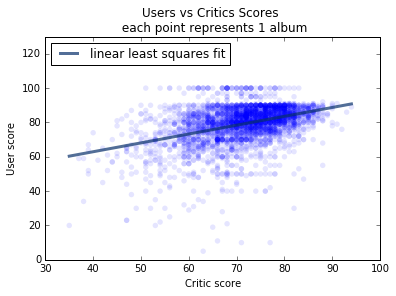

In [53]:
critics_clean = []
users_clean = []
for index, row in df.iterrows():
    if row['user_score'] != 'tbd' and row['critic_score'] != 'tbd':
        critics_clean.append(row['critic_score'])
        users_clean.append(row['user_score'])

tp.Scatter(critics_clean, users_clean, alpha=0.1)

corr = ts2.Corr(critics_clean, users_clean)
print("Pearson's correlation between critics' and users' scores:", "%.2f" % corr)

data = pd.Series(critics_clean), pd.Series(users_clean)
ht = analysis.CorrelationOneSidedPermute(data)
pvalue = ht.PValue()
print("Computed p-value:", pvalue)

inter, slope = ts2.LeastSquares(critics_clean, users_clean)
fit_xs, fit_ys = ts2.FitLine(critics_clean, inter, slope)
tp.Plot(fit_xs, fit_ys, label='linear least squares fit')
tp.Config(loc=2)
tp.Show(ylim=[0,130], xlabel='Critic score', ylabel='User score', title='Users vs Critics Scores \n each point represents 1 album')

residuals = ts2.Residuals(critics_clean, users_clean, inter, slope)
coefdeter = ts2.CoefDetermination(users_clean, residuals)

##### A linear model
Since the correlation is far from having an absolute value of 1, the linear relationship is nowhere near perfect.

However, say we still want to use critics' scores to predict users' scores based on this linear relationship, acknowledging that there will be errors in doing so. 

To use this linear relationship to predict users' score (a y-value, in the graph above) based on critics' score (an x-value), we will need to find a line that best fits the data. 

As each point on our best fit line is our predicted users' score for a given critics' score, the errors we make are the discrepancies between the actual and predicted users' scores -- termed "residuals." The line in the graph above minimizes the sum of the square of each of these errors. The errors are squared here as squaring makes all errors count postively towards this error sum, as well as gives an appropriately larger weight to larger errors. 

This process produces the line plotted on the graph above, with the following slope and y-intercept:

In [54]:
print("Slope:", "%.2f" % slope)
print("Y-intercept:", "%.2f" % inter)

Slope: 0.52
Y-intercept: 42.32


In [55]:
critics_mean = np.mean(critics_clean)
print("Mean CRITIC score:", "%.2f" % critics_mean)
print("Predicted USERS' score for an album with the mean CRITICS' score:", "%.2f" % ((slope * critics_mean) + inter))

Mean CRITIC score: 71.15
Predicted USERS' score for an album with the mean CRITICS' score: 79.01


(To note, our mean critics' score above -- 71.15 -- differs very slightly from the mean critics' score reportedly previously -- 71.02. This is because for this analysis, in order to compare critics' and users' scores for the same albums, I needed to remove albums for which either the critics' or users' score was 'tbd.' 

As noted earlier, 'tbd' is a value used by Metacritic for critics' or users' scores when the respective score has too few ratings to report. Metacritic reports 'tbd' for a critics' score if it has less than 4 critics' ratings. (http://www.metacritic.com/faq#item13) The required number of users' ratings to generate a non-'tbd' score is not reported.)

##### Goodness of fit
To quantify how well this line fits our data, I calculated:
+ 1) The Coefficient of Determination -- which measures the proportion of the variance in users' scores that is predicted with our linear model, and
+ 2) The root mean squared error (RMSE) of my predicted users' scores -- which is the standard deviation of the residuals

In [56]:
print("Coefficient of Determination:", "%.2f" % coefdeter)
print("RMSE:", "%.2f" % np.std(residuals))

Coefficient of Determination: 0.15
RMSE: 10.30


In [57]:
print("Standard deviation of sample users' scores:", "%.2f" % np.std(users_clean))

Standard deviation of sample users' scores: 11.20


The linear model does not have much predictive power, however. Since the standard deviation of our sample users' scores is 11.2, and the standard deviation of the residuals is 10.3, the reduction in RMSE from using this model is only 8.07%.

In [58]:
print("Reduction in RMSE from model:", "%.2f" % (100 * (np.std(users_clean) - np.std(residuals)) / np.std(users_clean)), "percent")

Reduction in RMSE from model: 8.07 percent


##### Hypothesis Testing this Linear Model
Lastly, I wanted to test whether the slope of this relationship found between critics' and users' scores is likely to have occurred simply by chance in my data sample. 

To do so, I conducted a hypothesis test, with the null hypothesis being that the slope of this line, if we had data for the entire population, would actually be zero. I used ideas and code from Downey's ThinkStats2, which simulated the null hypothesis with y-values (here, users' scores) randomly varying around their mean. (If there were constant variation around the mean, the least squares fit would be a horizontal line -- slope zero. Therefore, this simulates the likelihood that random variations would produce a slope of at least our apparent effect size.)

The test produced a p-value < .001, indicating that the slope we measured (0.52) would be extremely unlikely to occur due to chance if the null hypothesis were true.

In [59]:
ht = linear.SlopeTest(data)
print("Computed p-value:", ht.PValue())

Computed p-value: 0.0


### Conclusion

#### First albums
I began my project with the primary goal of investigating whether artists' first albums receive more favorable reviews than other albums do, both from casual listeners and from critics. 

In the aggregated data scraped from Metacritic.com, I found an apparent effect of casual listeners' rating bands' first albums 3.39% better than other albums -- and this turned out to be statistically significant, with a p-value < .001. I assumed that a user's opinion about a given album did not impact his or her decision to rate the album.

Critics, on the other hand, in my sample of data rated first albums 0.12% worse than other albums. This miniscule apparent effect would be likely to occur by chance if the null hypothesis were true. However, it is impossible to say what impact Metacritic's treatment of critics' scores (normalization and weighted averaging) had on these results.

#### Casual listeners rate albums more favorably than critics do
In the process of researching my initial question around first albums, I happened to notice that casual listeners, in Metacritic's data, rated albums 11.26% higher than critics did. This was a large effect, with a Cohen's D of 0.81, and was extremely unlikely to have occurred by chance in my sample (p-value < .001). 

The effect may, however, have been caused in part by Metacritic treating user scores and critics scores differently. Metacritic assigns unequal weights to the influence of various critics, and then normalizes the resulting scores via a process "akin to 'grading on a curve' in college... which prevents scores from clumping together."(http://www.metacritic.com/about-metascores) As I did not have the full details on this process, I had to simply state that it occurred and ignore it in my analysis. 

#### Estimating the population's mean first album user score 
I put myself in the shoes of a record company analyst, looking to interpret casual listeners' reviews of a newly signed band's first release. I found that the sample mean is an unbiased estimator for the population mean -- whereas the sample median is biased, in this case. 

The sample mean also produces a lower standard error than the sample median. That is to say, using the sample mean as an estimator would produce estimates that were less variable due to sampling error. 

As sample mean has a lower standard error and is unbiased, it was the better choice for an estimator for the population mean -- that is, users' mean rating of all albums ever released in the genres I sampled (Indie, Pop, Alternative, Rock). Based on my sample, this would yield an estimate of the population mean of 80.63.

#### Relationship between Critics' and Users' Scores
Critics' and users' scores in my data sample exhibited a moderate linear relationship (Pearson's correlation of 0.39) that is statistically significant (p-value < .001), and so would be very unlikely to occur in this sample if in the population, there is no linear relationship between the two score types.  

However, computing a best fit line via a least squares model did not lead to much predictive power (8% reduction in RMSE) despite the slope being statistically significant (p-value < .001).

Throughout this analysis as well, again, I had to ignore the potential effects of Metacritic's weighting and normalization of critics' scores. 

### Future work
##### Relationship between critics' and casual listeners' ratings
I found the merely moderate linear relationship between critics' and users' scores to be particularly interesting, and would like to delve further into this. Although it is the most prominent website I know that aggregates users' and critics' ratings of music, Metacritic's differing treatment of users' and critics' scores influenced any comparison of these different score types. My first step in looking further into this relationship would be to find a data set for aggregated critics' scores that weights reviewers equally, and does not perform any unexplained transformations on the data. 

Additionally, critics may sometimes be assigned albums to review, whereas for casual listeners, the decision to review an album would seem to be entirely theirs. What impact does this have on the linear relationship, if any? Ultimately, it would be a nice challenge to find a better model for predicting one score type -- users' or critics' -- given the other.

I am also fascinated by the difference in means between critics' and users' scores. Do critics simply have higher standards, and so review albums less favorably? Or, like the above, is the discrepancy influenced by selection bias in user review data, and by Metacritic's treatment of critics' scores? 

##### Reliability of each album's score
It also seems worthwhile to consider the number of reviewers per album, and perhaps eliminate those with only a few reviews from the data set. This would require significant additions to my Python scraper, but it would be interesting to see how this impacts my results. 